Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
import math
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [28]:
pickle_file = 'notMNISTfull.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (469114, 28, 28), (469114,))
('Validation set', (60000, 28, 28), (60000,))
('Test set', (18724, 28, 28), (18724,))


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [29]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (469114, 784), (469114, 10))
('Validation set', (60000, 784), (60000, 10))
('Test set', (18724, 784), (18724, 10))


In [0]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [16]:
def weight_variable(shape, prev_n_count=2):
    initial = tf.truncated_normal(shape, stddev=math.sqrt(2.0/prev_n_count))
    #initial = tf.truncated_normal(shape)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

def train_model(num_steps, checkpoint_every, batch_size, graph, is_saving=False, keep_prob = 0.5):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                         tf_batch_size: batch_size, tf_keep_prob: keep_prob}
            _, l, lr = session.run([optimizer, loss, learning_rate], feed_dict=feed_dict)
            if (step % checkpoint_every == 0):
                print("Minibatch loss at step %d: %f with learning rate %f" % (step, l, lr))
                train_accuracy = accuracy_l.eval(feed_dict={tf_train_dataset:batch_data, tf_train_labels: batch_labels,
                                                           tf_keep_prob: 1.0})
                print "step %d, training accuracy %g" % (step, train_accuracy)
                print("Validation accuracy: %g" % 
                    accuracy_l.eval(feed_dict={ tf_train_dataset: valid_dataset, tf_train_labels: valid_labels,
                                              tf_keep_prob: 1.0}))
                #save model
                if(is_saving):
                    saver.save(session, './model.ckpt', global_step=step)
        print("test accuracy %g" % accuracy_l.eval(feed_dict={ tf_train_dataset: test_dataset,
                                                              tf_train_labels: test_labels, tf_keep_prob: 1.0}))
        
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import random

def predict_letter(image, session):
    with session.as_default():
        probs = y_conv.eval(feed_dict={ tf_train_dataset: image, tf_train_labels: [[0,0,0,0,0,0,0,0,0,0]],
                                      tf_keep_prob: 1.0})
    #print probs
    return tf.argmax(probs,1).eval() #return index of max value

def find_incorrect(dataset, labels, session):
    with session.as_default():
        #tensor with True when prediction == label
        correct_predicitons = is_correct_prediction.eval(feed_dict={ tf_train_dataset: dataset,
                                                                    tf_train_labels: labels, tf_keep_prob: 1.0})
    #return indexes of invalid
    return np.where(correct_predicitons == False)
    

def display_sample(dataset, labels, title_label, session=None):    
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.3, hspace=1)
    fig = plt.figure()    
    fig.suptitle(title_label, color='white')
    fig.patch.set_facecolor('black')
    for d in range(0, 16):
        a=fig.add_subplot(gs[d])
        letter_idx = int(len(dataset)*random.random())
        #print(letter_idx)
        plt.imshow(dataset[letter_idx].reshape((28,28)), cmap = cm.Greys_r)
        l_title = chr(tf.argmax(labels[letter_idx],0).eval() + ord('A'))
        if session is not None:
            letter_class = predict_letter(dataset[letter_idx].reshape(1, -1), session)
            #print letter_class
            l_title = l_title + ' / ~' + chr(letter_class + ord('A'))
        a.set_title(l_title, color='white')
        a.axis('off')    
    plt.show()
    
def display_incorrect_sample(dataset, labels, title_label, num, session=None):    
    gs = gridspec.GridSpec(4, int(num / 4) + (0 if num % 4 == 0 else 1))
    gs.update(wspace=0.3, hspace=1)
    fig = plt.figure()
    fig.suptitle(title_label, color='white')
    fig.patch.set_facecolor('black')
    incorrect = find_incorrect(dataset, labels, session)[0]
    no_incorrect = len(incorrect)
    print('Incorrect no: %i' % no_incorrect)
    #get permutation of incorrects
    incorrect = incorrect[np.random.permutation(no_incorrect)]
    for d in range(0, num):
        a=fig.add_subplot(gs[d])             
        letter_idx = incorrect[d]
        #print(letter_idx)
        plt.imshow(dataset[letter_idx].reshape((28,28)), cmap = cm.Greys_r)
        l_title = chr(tf.argmax(labels[letter_idx],0).eval() + ord('A'))
        if session is not None:
            letter_class = predict_letter(dataset[letter_idx].reshape(1, -1), session)
            #print letter_class
            l_title = l_title + ' / ~' + chr(letter_class + ord('A'))
        a.set_title(l_title, color='white')
        a.axis('off')    
    plt.show()
    
def restore_and_display_test(graph, title):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.initialize_all_variables())
        #load model
        ckpt = tf.train.get_checkpoint_state('./')
        #print ckpt
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        print("test accuracy %g" % 
              accuracy_l.eval(feed_dict={ tf_train_dataset: test_dataset, tf_train_labels: test_labels,
                                        tf_keep_prob: 1.0}))
        display_sample(test_dataset, test_labels, title, sess)
        
def restore_and_display_random_incorrect(num_samples, graph, title):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.initialize_all_variables())
        #load model
        ckpt = tf.train.get_checkpoint_state('./')
        #print ckpt
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        print("test accuracy %g" % 
              accuracy_l.eval(feed_dict={ tf_train_dataset: test_dataset, tf_train_labels: test_labels,
                                        tf_keep_prob: 1.0}))
        display_incorrect_sample(test_dataset, test_labels, title, num_samples, sess)
        

    

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compue the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [1]:
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(None, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    tf_batch_size = tf.placeholder(tf.int32)

    # input layer variables
    weights_i = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_i = tf.Variable(tf.zeros([hidden_nodes]))
    
    #hidden layer
    h_fc1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_i) + biases_i)

    # output layer variables
    weights_o = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_o = tf.Variable(tf.zeros([num_labels]))
    #output operation
    logits_o = tf.matmul(h_fc1, weights_o) + biases_o
    y_conv = tf.nn.softmax(logits_o) #after softmax -> output probabilities / predictions
    #define loss    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_o, tf_train_labels) +
                          0.01*tf.nn.l2_loss(weights_i))                
    #decay learning rate
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.1, global_step * tf_batch_size, train_dataset.shape[0] / 2, 0.95, staircase=True)
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    #define operations to measure accuracy
    is_correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(tf_train_labels,1))
    accuracy_l = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    #saving mode
    saver = tf.train.Saver(max_to_keep=20)

NameError: name 'tf' is not defined

In [20]:
train_model(20001, 100, 512, graph, is_saving=True)

Initialized
Minibatch loss at step 0: 3487.843262 with learning rate 0.100000
step 0, training accuracy 0.3125
Validation accuracy: 0.2586
Minibatch loss at step 100: 2563.161133 with learning rate 0.100000
step 100, training accuracy 0.845703
Validation accuracy: 0.770633
Minibatch loss at step 200: 2098.815430 with learning rate 0.100000
step 200, training accuracy 0.8125
Validation accuracy: 0.77995
Minibatch loss at step 300: 1717.917236 with learning rate 0.095000
step 300, training accuracy 0.791016
Validation accuracy: 0.797233
Minibatch loss at step 400: 1416.304565 with learning rate 0.095000
step 400, training accuracy 0.857422
Validation accuracy: 0.808917
Minibatch loss at step 500: 1170.868896 with learning rate 0.095000
step 500, training accuracy 0.830078
Validation accuracy: 0.8048
Minibatch loss at step 600: 968.820679 with learning rate 0.090250
step 600, training accuracy 0.845703
Validation accuracy: 0.8212
Minibatch loss at step 700: 808.045776 with learning rate 0

For 1024h, decay with 0.1 start, and l2 regu 0.01. Regu 0.1 much too much, regu 0.001 too small, much less effect
(train_model(20001, 100, 512, graph, is_saving=True))

    Minibatch loss at step 19500: 0.320194 with learning rate 0.003387
    step 19500, training accuracy 0.955078
    Validation accuracy: 0.913083
    Minibatch loss at step 19600: 0.371944 with learning rate 0.003387
    step 19600, training accuracy 0.935547
    Validation accuracy: 0.913167
    Minibatch loss at step 19700: 0.374730 with learning rate 0.003217
    step 19700, training accuracy 0.927734
    Validation accuracy: 0.913217
    Minibatch loss at step 19800: 0.328619 with learning rate 0.003217
    step 19800, training accuracy 0.951172
    Validation accuracy: 0.9135
    Minibatch loss at step 19900: 0.340490 with learning rate 0.003217
    step 19900, training accuracy 0.941406
    Validation accuracy: 0.91295
    Minibatch loss at step 20000: 0.318129 with learning rate 0.003056
    step 20000, training accuracy 0.957031
    Validation accuracy: 0.91295
    test accuracy 0.96144


test accuracy 0.96144


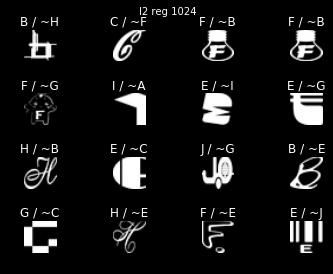

In [45]:
#restore_and_display_test(graph, "l2 reg 1024")
restore_and_display_random_incorrect(16, graph, "l2 reg 1024")

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [48]:
#save old datasets and trim + replace current
saved_train_dataset = np.copy(train_dataset)
saved_train_labels = np.copy(train_labels)

In [50]:
#trim to 5 batches
train_dataset = train_dataset[:512*5,:]
train_labels = train_labels[:512*5,:]

In [51]:
train_model(10001, 100, 512, graph, is_saving=True)

Initialized
Minibatch loss at step 0: 3437.287598 with learning rate 0.100000
step 0, training accuracy 0.273438
Validation accuracy: 0.232917
Minibatch loss at step 100: 2541.250488 with learning rate 0.100000
step 100, training accuracy 0.970703
Validation accuracy: 0.73705
Minibatch loss at step 200: 2079.891113 with learning rate 0.100000
step 200, training accuracy 1
Validation accuracy: 0.738483
Minibatch loss at step 300: 1703.886841 with learning rate 0.095000
step 300, training accuracy 1
Validation accuracy: 0.73845
Minibatch loss at step 400: 1408.931885 with learning rate 0.095000
step 400, training accuracy 1
Validation accuracy: 0.738533
Minibatch loss at step 500: 1165.021118 with learning rate 0.095000
step 500, training accuracy 1
Validation accuracy: 0.738567
Minibatch loss at step 600: 964.617310 with learning rate 0.090250
step 600, training accuracy 1
Validation accuracy: 0.73865
Minibatch loss at step 700: 805.244568 with learning rate 0.090250
step 700, training 

In [52]:
train_dataset = saved_train_dataset
train_labels = saved_train_labels

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [9]:
hidden_nodes = 1424

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(None, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    tf_batch_size = tf.placeholder(tf.int32)
    tf_keep_prob = tf.placeholder(tf.float32)

    # input layer variables
    weights_i = weight_variable([image_size * image_size, hidden_nodes], hidden_nodes)
    biases_i = bias_variable([hidden_nodes])
    
    #hidden layer
    h_fc1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_i) + biases_i)
    #drop it
    h_fc1_drop = tf.nn.dropout(h_fc1, tf_keep_prob)
    # output layer variables
    weights_o = weight_variable([hidden_nodes, num_labels], hidden_nodes)
    biases_o = bias_variable([num_labels])
    #output operation
    logits_o = tf.matmul(h_fc1_drop, weights_o) + biases_o
    y_conv = tf.nn.softmax(logits_o) #after softmax -> output probabilities / predictions
    #define loss    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_o, tf_train_labels)
                          + 0.01*tf.nn.l2_loss(weights_i))                
    #decay learning rate
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.1, global_step * tf_batch_size, train_dataset.shape[0] / 0.5, 0.95, staircase=True)
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #learning_rate = tf.constant(0.01)
    #optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    #define operations to measure accuracy
    is_correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(tf_train_labels,1))
    accuracy_l = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    #saving mode
    saver = tf.train.Saver(max_to_keep=20)

In [10]:
train_model(40001, 100, 512, graph, is_saving=True)

Initialized
Minibatch loss at step 0: 2.302583 with learning rate 0.100000
step 0, training accuracy 0.130859
Validation accuracy: 0.10205
Minibatch loss at step 100: 2.302460 with learning rate 0.100000
step 100, training accuracy 0.0996094
Validation accuracy: 0.0995833


KeyboardInterrupt: 

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [42]:
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(None, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    tf_batch_size = tf.placeholder(tf.int32)
    tf_keep_prob = tf.placeholder(tf.float32)

    # input layer variables
    weights_i = weight_variable([image_size * image_size, hidden_nodes], image_size * image_size)
    biases_i = bias_variable([hidden_nodes])
    
    #hidden layer
    h_fc1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_i) + biases_i)
    h_fc1_drop = tf.nn.dropout(h_fc1, tf_keep_prob)
    
    weights_h2 = weight_variable([hidden_nodes, hidden_nodes / 4], hidden_nodes)
    biases_h2 = bias_variable([hidden_nodes / 4])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, weights_h2) + biases_h2)
    h_fc2_drop = tf.nn.dropout(h_fc2, tf_keep_prob)
    
    weights_h3 = weight_variable([hidden_nodes / 4, hidden_nodes / 20], hidden_nodes / 4)
    biases_h3 = bias_variable([hidden_nodes / 20])
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, weights_h3) + biases_h3)        
    h_fc3_drop = tf.nn.dropout(h_fc3, tf_keep_prob)
    
    # output layer variables
    weights_o = weight_variable([hidden_nodes / 20, num_labels], hidden_nodes / 20)
    biases_o = bias_variable([num_labels])    
    #output operation
    logits_o = tf.matmul(h_fc3_drop, weights_o) + biases_o
    y_conv = tf.nn.softmax(logits_o) #after softmax -> output probabilities / predictions
    #define loss    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_o, tf_train_labels)
                        + (2.0/(3*hidden_nodes))*(tf.nn.l2_loss(weights_i)
                        + tf.nn.l2_loss(weights_h2)
                        + tf.nn.l2_loss(weights_h3)))
    #decay learning rate
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.1, global_step * tf_batch_size, train_dataset.shape[0] / 1, 0.95, staircase=True)
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #learning_rate = tf.constant(0.01)
    #optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    #define operations to measure accuracy
    is_correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(tf_train_labels,1))
    accuracy_l = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    #saving mode
    saver = tf.train.Saver(max_to_keep=20)

In [43]:
train_model(200001, 100, 256, graph, is_saving=True, keep_prob = 0.8)

Initialized
Minibatch loss at step 0: 3.148685 with learning rate 0.100000
step 0, training accuracy 0.207031
Validation accuracy: 0.188617
Minibatch loss at step 100: 1.461157 with learning rate 0.100000
step 100, training accuracy 0.777344
Validation accuracy: 0.818133
Minibatch loss at step 200: 1.283906 with learning rate 0.100000
step 200, training accuracy 0.863281
Validation accuracy: 0.833333
Minibatch loss at step 300: 1.354653 with learning rate 0.100000
step 300, training accuracy 0.796875
Validation accuracy: 0.84
Minibatch loss at step 400: 1.039869 with learning rate 0.100000
step 400, training accuracy 0.925781
Validation accuracy: 0.843283
Minibatch loss at step 500: 1.192185 with learning rate 0.100000
step 500, training accuracy 0.863281
Validation accuracy: 0.847367
Minibatch loss at step 600: 1.291822 with learning rate 0.100000
step 600, training accuracy 0.828125
Validation accuracy: 0.850633
Minibatch loss at step 700: 1.176693 with learning rate 0.100000
step 70

KeyboardInterrupt: 

test accuracy 0.971534
Incorrect no: 533


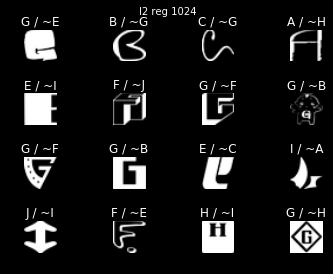

In [44]:
#restore_and_display_test(graph, "l2 reg 3h")
restore_and_display_random_incorrect(16, graph, "l2 reg 1024")